In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

In [43]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [44]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [95]:
#load data
# data can be downloaded from https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
data_path = 'E:\AllPrograms\Datasets\Sarcasm_Headlines_Dataset.json\Sarcasm_Headlines_Dataset.json'
data = pd.read_json(data_path, lines=True)

In [47]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [48]:
#extract the headlines
X = data['headline']
y = data['is_sarcastic']

In [49]:
X.head()

0    former versace store clerk sues over secret 'b...
1    the 'roseanne' revival catches up to our thorn...
2    mom starting to fear son's web series closest ...
3    boehner just wants wife to listen, not come up...
4    j.k. rowling wishes snape happy birthday in th...
Name: headline, dtype: object

In [50]:
#download stop words from nlkt

In [51]:
stop_words = set(stopwords.words('english')) 

In [52]:
# we will words preserver the word "not", as it would chnage meaning
stop_words.remove('not')

In [67]:
#preprocess data, remove stopwords, perform stemming and lemmatization
def process(X, tokenizer, lemmatizer):
    result = []
    for doc in X:
        token_list = []
        doc = doc.lower()
        #replace words "n't" with not
        doc = re.sub("n't", ' not ', doc)
        for token in tokenizer(doc):
            if token not in stop_words and len(token) > 2:
                lemma = lemmatizer.lemmatize(token)                
                token_list.append(lemma)
        result.append(" ".join(token_list))
    return result

In [68]:
X_processed = process(X, word_tokenize, WordNetLemmatizer())

In [69]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.20, random_state=42)

In [70]:
#check train and test size
print('x_train_shape:', len(X_train))
print('y_train_shape:', len(y_train))
print('x_test_shape:', len(X_test))
print('y_test_shape:', len(y_test))

x_train_shape: 21367
y_train_shape: 21367
x_test_shape: 5342
y_test_shape: 5342


In [71]:
#define the cosntants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 100
TRUNC_TYPE_POST = 'pre'
OOV_TOKEN = "<OOV>"

In [72]:
#let's preprocess the data, learn vocab, convert into document term matrix
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

In [73]:
word_index = tokenizer.word_index

In [74]:
#print first 10 words in the dictionary
i = 0
for item in word_index.items():
    if i >= 10:
        break
    print(item)
    i += 1

('<OOV>', 1)
('not', 2)
('trump', 3)
('new', 4)
('man', 5)
('woman', 6)
('year', 7)
('say', 8)
('report', 9)
('one', 10)


In [75]:
#get the sequences from text and do padding
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_pad_sequences = pad_sequences(sequences=X_train_sequences, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE_POST)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_pad_sequences = pad_sequences(sequences=X_test_sequences, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE_POST)

In [76]:
print(X_train_pad_sequences[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  560 3603 3604   27  232
  196  577]


In [85]:
#create model
def create_model():    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [86]:
model = create_model()

In [87]:
#train the model
trained_model = model.fit(x=X_train_pad_sequences,
                          y=y_train,
                          batch_size=32,
                          epochs=50,
                          validation_data=(X_test_pad_sequences, y_test))

Train on 21367 samples, validate on 5342 samples
Epoch 1/50
21367/21367 [==============================] - 43s 2ms/sample - loss: 0.5016 - accuracy: 0.7462 - val_loss: 0.4316 - val_accuracy: 0.7960
Epoch 2/50
21367/21367 [==============================] - 45s 2ms/sample - loss: 0.3162 - accuracy: 0.8654 - val_loss: 0.4571 - val_accuracy: 0.7933
Epoch 3/50
21367/21367 [==============================] - 43s 2ms/sample - loss: 0.2282 - accuracy: 0.9071 - val_loss: 0.5071 - val_accuracy: 0.7924
Epoch 4/50
21367/21367 [==============================] - 42s 2ms/sample - loss: 0.1627 - accuracy: 0.9386 - val_loss: 0.5508 - val_accuracy: 0.7900
Epoch 5/50
21367/21367 [==============================] - 41s 2ms/sample - loss: 0.1227 - accuracy: 0.9546 - val_loss: 0.7129 - val_accuracy: 0.7802
Epoch 6/50
21367/21367 [==============================] - 41s 2ms/sample - loss: 0.0893 - accuracy: 0.9665 - val_loss: 0.8220 - val_accuracy: 0.7851
Epoch 7/50
21367/21367 [==============================] -

In [88]:
# save the entire model as HDF5
model.save('sarcasm_model.h5')

In [91]:
# let's plot training/validation loss/accuracy
def plot(model, category, epochs): 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    x = range(epochs)
    ax.plot(x, model.history.get(category), color='tab:blue')
    ax.plot(x, model.history.get('val_'+category), color='tab:red')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train_'+category, 'validation_'+category])
    plt.show()

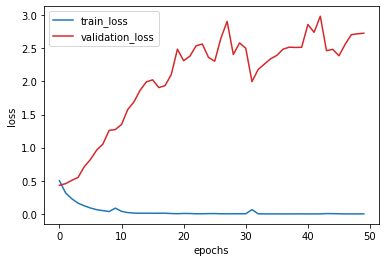

In [92]:
plot(trained_model, 'loss', 50)

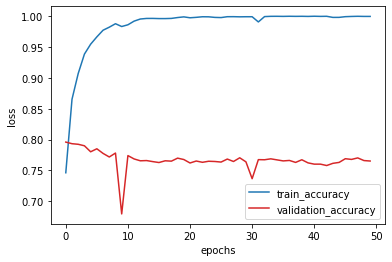

In [93]:
plot(trained_model, 'accuracy', 50)

In [94]:
#As we see from above trainibg/validation accuracy and loss plots, there seems to be overfitting.
#We can try out different combination of vocab size, max length and embedding dimenstion.
#we may also use Dropouts to reduce overfitting 